# HSC-ACT Offset Distribution

With the HSC-ACT crossmatch catalog, one can fit the offsets distribution.

In [1]:
## Import packages
import numpy as np
from scipy.optimize import minimize
from scipy import integrate

from astropy.table import Table
from astropy.io import fits, ascii

import matplotlib.pyplot as plt

## Get list of offsets

In [2]:
# read in the crossmatch catalog
cm_catalog = Table.read('HSC_ACT_crossmatch.fits', hdu=1)
# read in "Cause of miscentering" column
cause_of_misc = cm_catalog['Cause of miscentering']

In [3]:
# create a flag indicating if a miscentered cluster should be excluded in the fitted distribution
shape = (len(cm_catalog))

reasons_for_exclusion = {'Artifact', 'Misidentified CG', 'Deblending', 'False match', 
                         'False signal', 'Star'}
exclude_from_distro = [(cause in reasons_for_exclusion) for cause in cause_of_misc]
exclude_from_distro = np.array(exclude_from_distro)

In [4]:
offsets_fiducial = cm_catalog['Offset (Mpc)']

exclude_clusters = True
if exclude_clusters:
    offsets = offsets_fiducial[~exclude_from_distro]
else:
    offsets = offsets_fiducial

## Create offsets model

In [5]:
def prob_dens_well_centered(x, sigma1):
    '''
    A model for the offset distribution for well-centered clusters. See
    the documentation for offset_model for a description.
    
    
    ARGUMENTS
    ---------
    x: physical offset
    sigma1: characteristic offset for well-centered clusters
    
    '''
    
    return (x / sigma1**2) * np.exp(-x**2 / (2*sigma1**2))

def prob_dens_mis_centered(x, sigma2):
    '''
    A model for the offset distribution for miscentered clusters. See
    the documentation for offset_model for a description.
    
    ARGUMENTS
    ---------
    x: physical offset
    sigma2: characteristic offset for miscentered clusters
    
    '''
    
    return (x / sigma2**2) * np.exp(-x**2 / (2*sigma2**2))

def prob_dens_linear(x, slope=0.5):
    '''
    A linear component of the offsets model that represents random 
    superpositions of ACT and HSC clusters. 
    
    
    '''
    
    return slope*x

def offset_model(x, f_cen, sigma1, sigma2):
    '''
    
    A two-component model for the centering offset distribution. Returns 
    the probability density at a given offset. All arguments are in Mpc.
    
    This is equation 9 in the CAMIRA catalog paper (Oguri et al. 2018).
    Both the well-centered population and the miscentered population are
    modeled with a Rayleigh distribution.

    ARGUMENTS
    ---------
    x: physical offset
    f_cen: fraction of well-centered clusters
    sigma1: characteristic offset for well-centered clusters
    sigma2: characteristic offset for miscentered clusters
    
    '''
    
    prob_dens_well = prob_dens_well_centered(x, sigma1)
    prob_dens_mis = prob_dens_mis_centered(x, sigma2)
    
    return f_cen * prob_dens_well + (1 - f_cen) * prob_dens_mis

def offset_model_fixed_sig1(x, f_cen, sigma2, sigma1=0.1):
    '''
    
    Same as offset_model, except sigma1 is a fixed value. 
    All arguments are in Mpc.
    

    ARGUMENTS
    ---------
    x: physical offset
    f_cen: fraction of well-centered clusters
    sigma2: characteristic offset for miscentered clusters
    sigma1: characteristic offset for well-centered clusters; default
    value is 0.1 Mpc
    
    '''
    
    prob_dens_well = prob_dens_well_centered(x, sigma1)
    prob_dens_mis = prob_dens_mis_centered(x, sigma2)
    
    return f_cen * prob_dens_well + (1 - f_cen) * prob_dens_mis

def offset_model_fixed_sig1_3comp(x, f_cen, sigma2, slope, sigma1=0.15):
    '''
    
    3-component model of the offsets distribution. The well-centered 
    population is modeled with a Rayleigh distribution with (fixed) sigma1,
    the miscentered population is a Rayleigh distribution with sigma2, and
    the random superposition population is linear.
    
    All arguments are in Mpc.
    

    ARGUMENTS
    ---------
    x: physical offset
    f_cen: fraction of well-centered clusters
    slope: characteristic slope of random superposition population
    sigma2: characteristic offset for miscentered clusters
    sigma1: characteristic offset for well-centered clusters; default
    value is 0.1 Mpc
    
    '''
    
    prob_dens_well = prob_dens_well_centered(x, sigma1)
    prob_dens_mis = prob_dens_mis_centered(x, sigma2)
    prob_dens_random = prob_dens_linear(x, slope)
    
    return f_cen * prob_dens_well + (1 - f_cen) * prob_dens_mis + prob_dens_random

def objective_fn(params, offsets):
    '''
    
    Given the model parameters and the set of offsets, compute
    the objective as a log likelihood.
    
    ARGUMENTS
    ----------
    params: tunable parameters in offset_model
    offsets: set of physical offsets (Mpc; same as offset_model)
    
    '''
    
    f_cen, sig1, sig2 = params
    probs = offset_model(offsets, f_cen, sig1, sig2)
    
    obj = -np.sum(np.log(probs)) # goal: *minimize* log likelihood
    return obj

def objective_fn_fixed_sig1(params, offsets, fixed_sig1):
    '''
    
    Given the parameters for the 2-component model (with fixed sig1) and 
    the set of offsets, compute the objective as a log likelihood.
    
    ARGUMENTS
    ----------
    params: tunable parameters in offset_model
    offsets: set of physical offsets (Mpc; same as offset_model)
    fixed_sig1: fixed value of sigma1
    
    '''
    
    f_cen, sig2 = params
    
    probs = offset_model_fixed_sig1(offsets, f_cen, sig2, sigma1=fixed_sig1)
    
    obj = -np.sum(np.log(probs)) # goal: *minimize* log likelihood
    return obj

def objective_fn_fixed_sig1_3comp(params, offsets, fixed_sig1):
    '''
    
    Given the parameters for the 3-component model and the set of offsets, 
    compute the objective as a log likelihood.
    
    ARGUMENTS
    ----------
    params: tunable parameters in offset_model
    offsets: set of physical offsets (Mpc; same as offset_model)
    fixed_sig1: fixed value of sigma1
    
    '''
    
    f_cen, sig2, slope = params
    
    probs = offset_model_fixed_sig1_3comp(offsets, f_cen, sig2, slope, sigma1=fixed_sig1)
    
    obj = -np.sum(np.log(probs)) # goal: *minimize* log likelihood
    return obj

## Fit distribution to model

In [6]:
use_fixed_sig1 = True
use_3comp = False

if use_fixed_sig1:
    fixed_sig1 = 0.15
    sig1_best = fixed_sig1
    
    if use_3comp:
        initial_guess = (0.75, 0.17, 0.1)
        best_guess = minimize(fun=objective_fn_fixed_sig1_3comp, x0=initial_guess, \
                        args=(offsets, fixed_sig1), method='L-BFGS-B', \
                              bounds=((0., 1), (0.01, 1.), (0., 0.2)))
        f_best, sig2_best, slope_best = best_guess.x
    else:
        initial_guess = (0.75, 0.17)
        best_guess = minimize(fun=objective_fn_fixed_sig1, x0=initial_guess, \
                    args=(offsets, fixed_sig1), method='L-BFGS-B', \
                          bounds=((0., 1), (0.01, 1.)))
        f_best, sig2_best = best_guess.x
else:
    initial_guess = (0.75, 0.15, 0.35)
    best_guess = minimize(fun=objective_fn, x0=initial_guess, args=(offsets), \
                         method='L-BFGS-B', bounds=((0., 1), (1e-4, 0.3), (0.1, 1.)))
    f_best, sig1_best, sig2_best = best_guess.x

print(best_guess)

      fun: -109.36924933735324
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.84217093e-06,  0.00000000e+00])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 51
      nit: 13
     njev: 17
   status: 0
  success: True
        x: array([0.91010552, 0.39171723])


## Plot distribution and model together

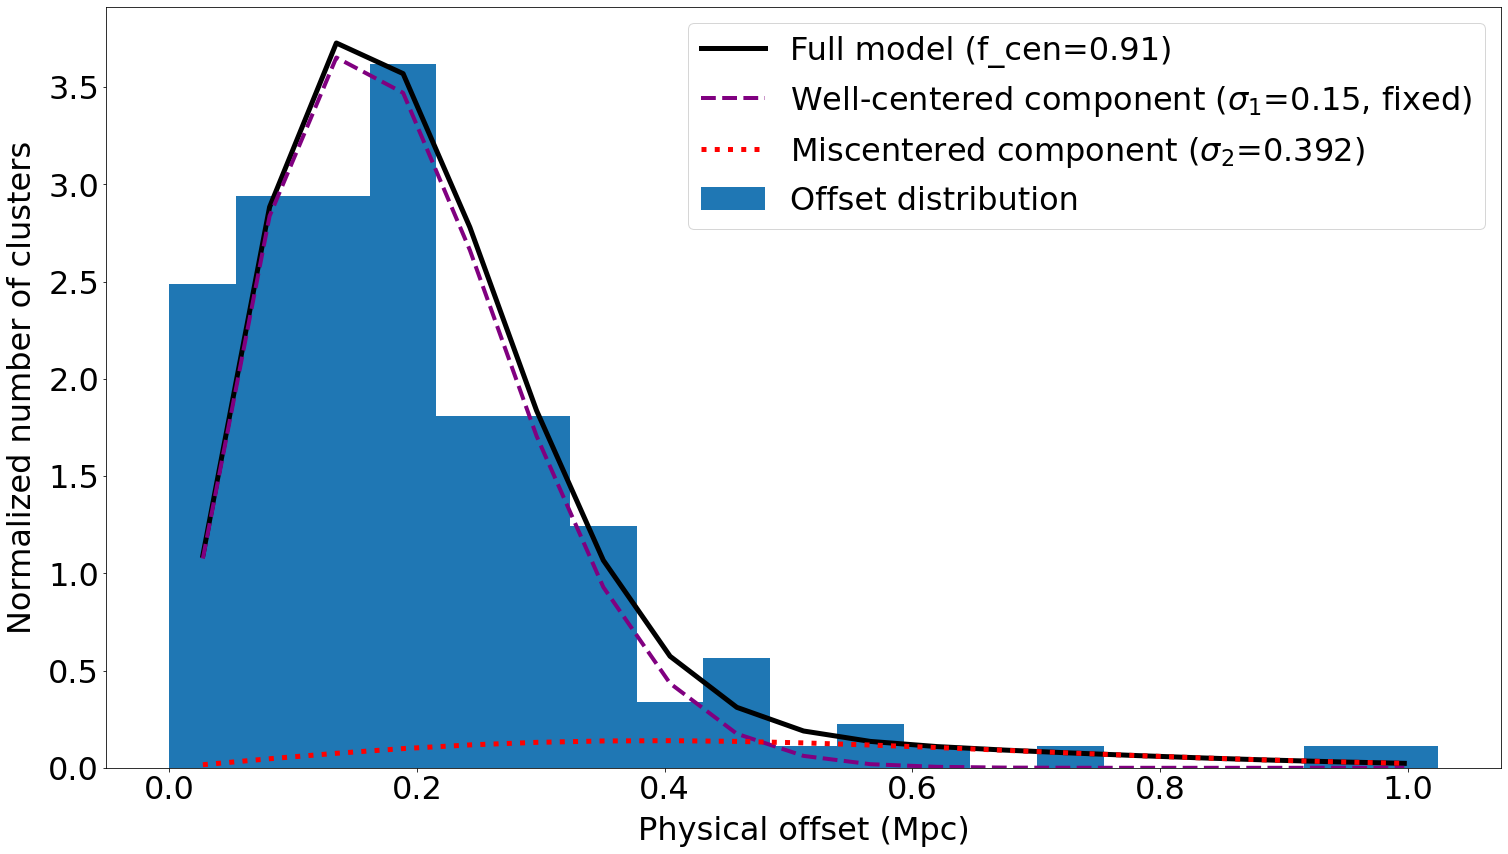

In [7]:
## set global font size
plt.rcParams.update({'font.size':32})

## Plot offset distribution (cross-match)
fig = plt.figure(figsize=(25,14))
fig.patch.set_facecolor('white')

use_title = False
if use_title:
    plot_title = f"ACT-HSC offset distribution"
    plt.suptitle(plot_title, fontsize=30, y=0.95)

    plot_subtitle = f'n = {len(offsets)}'
    if exclude_clusters:
        plot_subtitle += '; clusters with an identifiable, non-astrophysical source of miscentering are excluded.'
    plt.title(plot_subtitle, fontsize=24, pad=10)

## Data sample
num_bins = 20
max_offset = np.max(offsets)
bins = np.linspace(0, max_offset, num=num_bins)
hist = plt.hist(offsets, bins=bins, \
                label=f"Offset distribution", density=True)
plt.xlabel("Physical offset (Mpc)", labelpad=10)
plt.ylabel("Normalized number of clusters", labelpad=10)

## Model
x_axis = (hist[1][:-1] + hist[1][1:]) / 2 # midpoints of histogram bins
# plot full model
norm_factor_full = 1 / \
        integrate.quad(offset_model, 0, max_offset, args=(f_best, sig1_best, sig2_best))[0]

# plot the full model
if use_3comp:
    model = norm_factor_full*offset_model_fixed_sig1_3comp(x_axis, f_best, sig2_best,\
                                                        slope_best, fixed_sig1)
else:
    model = norm_factor_full*offset_model_fixed_sig1(x_axis, f_best, sig2_best,\
                                                        fixed_sig1)
    
plt.plot(x_axis, model, \
    label=f"Full model (f_cen={np.round(f_best,3)})", color='black', linewidth=5)

# plot the model's components separately
if use_fixed_sig1:
    plt.plot(x_axis, norm_factor_full*f_best*prob_dens_well_centered(x_axis, sig1_best),
         label=f"Well-centered component ($\sigma_1$={np.round(sig1_best,3)}, fixed)", \
         color='purple', linestyle='--', linewidth=4)
else:
    plt.plot(x_axis, norm_factor_full*f_best*prob_dens_well_centered(x_axis, sig1_best),
         label=f"Well-centered component ($\sigma_1$={np.round(sig1_best,3)})", \
         color='purple', linestyle='--', linewidth=4)

plt.plot(x_axis, norm_factor_full*(1-f_best)*prob_dens_mis_centered(x_axis, sig2_best), 
         label=f"Miscentered component ($\sigma_2$={np.round(sig2_best,3)})", \
         color='red', linestyle=':', linewidth=5)

if use_3comp:
    plt.plot(x_axis, prob_dens_linear(x_axis, slope_best), 
         label=f"Linear component (slope={np.round(slope_best,3)})", \
         color='green', linestyle='--', linewidth=5)

plt.legend()
plt.savefig("Figures/MNRAS_Paper_Figures/Model/cleaned_distro.png", bbox_inches='tight')
plt.show()

## Analyze fit

We assign the labels of "well-centered" and "miscentered" to the cross-match clusters. 


Below, the cutoff for well-centered vs. miscentered is determined. For example: Assume $f_{cen}=0.75$. If a cluster's centering offset is above the 75th percentile of all offsets in the sample, then it is miscentered; otherwise, it is well-centered.

In [8]:
well_centered_cutoff = np.percentile(offsets, 100*f_best)
print(f'well_centered_cutoff: {np.round(well_centered_cutoff, 3)} Mpc')
is_well_centered = [(offset < well_centered_cutoff) for offset in offsets]
is_well_centered = np.asarray(is_well_centered)

well_centered_cutoff: 0.373 Mpc


Below, we determine the number of clusters whose offset falls between 331 and 373 kpc. (The 331 kpc came from the fiducial crossmatch, and the 373 kpc comes from this "cleaned" crossmatch.)

In [13]:
# offsets_sorted = np.sort(offsets)
cutoff1 = 0.331
cutoff2 = 0.373

between_cutoffs = (offsets > cutoff1) & (offsets < cutoff2)
#offsets[between_cutoffs]

# examine miscentering causes of the clusters in this offset range
between_cutoffs_fiducial = (offsets_fiducial > cutoff1) & (offsets_fiducial < cutoff2)
# print clusters in cleaned sample in this offset range
cm_catalog[between_cutoffs_fiducial & ~exclude_from_distro]

HSC name,HSC RA (deg),HSC dec (deg),ACT name,ACT RA (deg),ACT dec (deg),HSC z,HSC richness,ACT SNR,Offset (Mpc),Miscentered?,Merging?,Cause of miscentering
bytes15,float64,float64,bytes20,float64,float64,float64,float64,float64,float64,bool,bool,bytes20
C19a1sW01272,35.481354,-3.68159,ACT-CL J0221.9-0340,35.481415,-3.669552,1.052,32.01,6.229,0.351,True,True,Merger
C19a1sW02098,130.602173,0.54322,ACT-CL J0842.3+0033,130.595658,0.554184,1.028,36.414,4.78,0.37,True,True,Merger
C19a1sW02334,132.127353,-1.360332,ACT-CL J0848.5-0122,132.13888,-1.367742,0.616,16.443,4.903,0.3337,True,True,Merger
C19a1sW03508,139.709235,2.200894,ACT-CL J0918.7+0211,139.686703,2.190027,0.266,54.374,4.464,0.3682,True,True,Merger
C19a1sW05554,153.679031,3.176877,ACT-CL J1014.6+0310,153.666752,3.180976,0.7381,34.751,4.643,0.3395,True,True,Merger
C19a1sW08377,182.564078,3.354489,ACT-CL J1210.2+0321,182.55591,3.364153,1.0324,42.004,6.952,0.3672,True,False,None apparent
C19a1sW09451,194.603949,0.738087,ACT-CL J1258.4+0043,194.620819,0.733333,0.4,31.104,4.666,0.339,True,False,None apparent
C19a1sW10814,216.234116,-1.697835,ACT-CL J1424.9-0141,216.238952,-1.686031,0.948,37.315,4.502,0.3629,True,False,None apparent
C19a1sW15945,352.312526,0.94813,ACT-CL J2329.2+0056,352.321084,0.937561,0.742,25.08,4.663,0.3578,True,False,Merger


In [14]:
# examine miscentered clusters in cleaned sample
is_miscentered_cleaned = (offsets_fiducial > cutoff2) & ~exclude_from_distro
cm_catalog[is_miscentered_cleaned]

HSC name,HSC RA (deg),HSC dec (deg),ACT name,ACT RA (deg),ACT dec (deg),HSC z,HSC richness,ACT SNR,Offset (Mpc),Miscentered?,Merging?,Cause of miscentering
bytes15,float64,float64,bytes20,float64,float64,float64,float64,float64,float64,bool,bool,bytes20
C19a1sW00048,0.570211,1.532472,ACT-CL J0002.3+0131,0.583333,1.524909,0.81,34.607,4.615,0.411,True,False,Multiple possible
C19a1sW00955,33.337991,-6.076813,ACT-CL J0213.3-0605,33.337377,-6.099905,0.702,48.262,6.518,0.5949,True,False,Multiple possible
C19a1sW01237,35.231588,-3.563314,ACT-CL J0220.9-0332,35.236988,-3.547877,1.0139,36.94,5.137,0.4729,True,False,Multiple possible
C19a1sW01596,38.070717,-6.320418,ACT-CL J0232.2-0617,38.052728,-6.294417,1.1521,22.545,4.289,0.9361,True,True,Merger
C19a1sW02209,131.259589,1.442025,ACT-CL J0845.0+0127,131.25981,1.46531,0.4165,29.912,5.858,0.4615,True,False,Multiple possible
C19a1sW04184,143.801208,0.825611,ACT-CL J0935.2+0048,143.80869,0.800777,0.3521,78.408,13.913,0.463,True,True,Merger
C19a1sW04937,149.04878,1.992959,ACT-CL J0956.1+0158,149.044615,1.980276,0.946,43.346,5.947,0.3796,True,True,Merger
C19a1sW05441,152.43191,2.903656,ACT-CL J1009.7+0255,152.428211,2.926406,0.382,39.706,6.556,0.4333,True,False,Multiple possible
C19a1sW06808,171.452369,0.171272,ACT-CL J1125.7+0010,171.431499,0.178289,0.748,42.912,4.855,0.5811,True,True,Merger
